#  Classification de Tanks - Étude Comparative CNN vs Transfer Learning

## 📋 Contexte du Projet
**Objectif** : Développer un système de classification automatique d'images de tanks pour accélérer l'indexation d'une base de données d'images militaires.

##  Approches Comparées
1. **CNN Personnalisé** : Réseau convolutif développé from scratch
2. **Transfer Learning** : EfficientNet-B0 pré-entraîné sur ImageNet

##  Critères de Comparaison
- Accuracy de validation
- Temps d'entraînement
- Nombre de paramètres
- Convergence

---

## 1️ Imports et Configuration

In [ ]:
import json
import time
from pathlib import Path

import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
try:
    from tqdm.notebook import tqdm
    print("Mode notebook interactif activé")
except ImportError:
    from tqdm import tqdm
    print("Mode texte activé")

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Mode notebook interactif activé
PyTorch version: 2.5.1
CUDA available: True
CUDA version: 12.1
GPU: NVIDIA GeForce RTX 4060 Laptop GPU


In [ ]:
# CONFIGURATION GLOBALE

DATASET_PATH = "Projet_groupe_tank_model/data/battle-tank-dataset"
BATCH_SIZE = 32
EPOCHS = 5  
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Création des dossiers de sauvegarde
Path("artifacts/cnn_custom").mkdir(parents=True, exist_ok=True)
Path("artifacts/transfer_learning").mkdir(parents=True, exist_ok=True)
Path("artifacts/comparison").mkdir(parents=True, exist_ok=True)

print("="*70)
print("CONFIGURATION DU PROJET")
print("="*70)
print(f"Device: {DEVICE}")
if torch.cuda.is_available():
    print(f"Mémoire GPU: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
print(f"Batch size: {BATCH_SIZE}")
print(f"Époques: {EPOCHS}")
print(f"Dataset: {DATASET_PATH}")
print("="*70)

CONFIGURATION DU PROJET
Device: cuda
Mémoire GPU: 8.59 GB
Batch size: 32
Époques: 5
Dataset: Projet_groupe_tank_model/data/battle-tank-dataset


## 2 Préparation des Données

### Data Augmentation
Techniques utilisées pour augmenter la robustesse du modèle :
- **RandomCrop** : Découpage aléatoire pour variation de cadrage
- **RandomHorizontalFlip** : Symétrie horizontale (tanks vus de différents angles)
- **RandomRotation** : Rotation jusqu'à 20° (différentes positions)
- **ColorJitter** : Variations de luminosité, contraste, saturation (conditions météo/éclairage)
- **RandomAffine** : Translations légères (position dans l'image)

In [ ]:
# TRANSFORMATIONS ET DATA AUGMENTATION

train_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])


val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

print("✓ Transformations configurées avec data augmentation")

✓ Transformations configurées avec data augmentation


In [ ]:

print("\nChargement des données...")

train_dataset = datasets.ImageFolder(Path(DATASET_PATH) / "train", transform=train_tf)
val_dataset = datasets.ImageFolder(Path(DATASET_PATH) / "validation", transform=val_transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
    persistent_workers=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE * 2,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
    persistent_workers=True,
)

num_classes = len(train_dataset.classes)
class_names = train_dataset.classes

print("="*70)
print("STATISTIQUES DU DATASET")
print("="*70)
print(f"Nombre de classes: {num_classes}")
print(f"Classes: {class_names}")
print(f"Images d'entraînement: {len(train_dataset):,}")
print(f"Images de validation: {len(val_dataset):,}")
print(f"Batches d'entraînement: {len(train_loader)}")
print(f"Batches de validation: {len(val_loader)}")
print("="*70)


Chargement des données...
STATISTIQUES DU DATASET
Nombre de classes: 67
Classes: ['AMX-13', 'AMX-30', 'Al-Zarrar', 'Altay', 'Ariete', 'Arjun MBT', 'BM Oplot', 'CM-11 Brave Tiger', 'Centurion', 'Challenger 1', 'Challenger 2', 'Chieftain', 'Chonma-ho', 'K1', 'K2 Black Panther', 'Kampfpanzer Leopard', 'Karrar', 'Leclerc', 'Leopard 2', 'Leopard 2A6E', 'M-84', 'M-84 Molf', 'M-84A4 Sniper', 'M-84D', 'M-95 Degman', 'M1A2', 'M4 Sherman', 'M47 Patton', 'M48A5', 'M60 A3', 'M60T', 'MBT-2000', 'Magach 6', 'Merkava Mk', 'OF-40 Mk.2', 'PT-91M', 'Pokpung-ho', 'Ramses II', 'Sabrah', 'T-14 Armata', 'T-34', 'T-55', 'T-62', 'T-64', 'T-72', 'T-72M4 CZ', 'T-80', 'T-80U', 'T-90', 'TR-85', 'Tank EX', 'Tanque Argentino Mediano', 'Tariq', 'Type 10', 'Type 59', 'Type 59 Durjoy', 'Type 69', 'Type 74', 'Type 85-IIAP', 'Type 88', 'Type 90', 'Type 96', 'Type 99', 'VT-1A', 'VT-5', 'Vickers Mk 3', 'Zulfiqar MBT']
Images d'entraînement: 50,519
Images de validation: 21,053
Batches d'entraînement: 1579
Batches de valid

---
# 🔬 APPROCHE 1 : CNN PERSONNALISÉ



In [ ]:
# DÉFINITION DU CNN PERSONNALISÉ

class CustomCNN(nn.Module):
    
    
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        
      
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
      
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
     
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
       
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        
      
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes)
        )
        
   
        self._initialize_weights()
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
    def _initialize_weights(self):
       
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

print("✓ Architecture CNN personnalisée définie")

✓ Architecture CNN personnalisée définie


In [ ]:
# CRÉATION DU CNN PERSONNALISÉ

print("\n" + "="*70)
print("APPROCHE 1: CNN PERSONNALISÉ")
print("="*70)

cnn_model = CustomCNN(num_classes).to(DEVICE)


total_params = sum(p.numel() for p in cnn_model.parameters())
trainable_params = sum(p.numel() for p in cnn_model.parameters() if p.requires_grad)

print(f"\nArchitecture:")
print(f"   Total paramètres: {total_params:,}")
print(f"   Paramètres entraînables: {trainable_params:,}")
print(f"   Nombre de couches: {len(list(cnn_model.modules()))}")
print("="*70)


APPROCHE 1: CNN PERSONNALISÉ

Architecture:
   Total paramètres: 111,717,763
   Paramètres entraînables: 111,717,763
   Nombre de couches: 42


In [7]:

# ENTRAÎNEMENT DU CNN PERSONNALISÉ


# Configuration de l'entraînement
cnn_criterion = nn.CrossEntropyLoss()
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=1e-3, weight_decay=1e-4)
cnn_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    cnn_optimizer, mode='max', factor=0.5, patience=2
)

# Historique
cnn_history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'epoch_times': [],
    'best_val_acc': 0.0
}

print("\n DÉBUT DE L'ENTRAÎNEMENT DU CNN PERSONNALISÉ")
print("="*70)

cnn_start_time = time.time()

for epoch in range(EPOCHS):
    epoch_start = time.time()
    
    # PHASE D'ENTRAÎNEMENT 
    cnn_model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]")
    for images, labels in train_pbar:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        cnn_optimizer.zero_grad()
        outputs = cnn_model(images)
        loss = cnn_criterion(outputs, labels)
        loss.backward()
        cnn_optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)
        
        train_pbar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'acc': f"{100.0 * train_correct / train_total:.2f}%"
        })
    
    avg_train_loss = train_loss / train_total
    train_acc = train_correct / train_total
    
    # PHASE DE VALIDATION 
    cnn_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]")
        for images, labels in val_pbar:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            outputs = cnn_model(images)
            loss = cnn_criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
            
            val_pbar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'acc': f"{100.0 * val_correct / val_total:.2f}%"
            })
    
    avg_val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    
   
    cnn_scheduler.step(val_acc)
    
    epoch_time = time.time() - epoch_start
    
    # Sauvegarde
    if val_acc > cnn_history['best_val_acc']:
        cnn_history['best_val_acc'] = val_acc
        torch.save(cnn_model.state_dict(), "artifacts/cnn_custom/best_model.pt")
    
    
    cnn_history['train_loss'].append(avg_train_loss)
    cnn_history['train_acc'].append(train_acc)
    cnn_history['val_loss'].append(avg_val_loss)
    cnn_history['val_acc'].append(val_acc)
    cnn_history['epoch_times'].append(epoch_time)
    
   
    print(f"\n Epoch {epoch+1}/{EPOCHS} Summary:")
    print(f"   Train → Loss: {avg_train_loss:.4f} | Acc: {train_acc:.2%}")
    print(f"   Val   → Loss: {avg_val_loss:.4f} | Acc: {val_acc:.2%}")
    print(f"   Time: {epoch_time:.2f}s")
    if val_acc == cnn_history['best_val_acc']:
        print(f"   Nouveau meilleur modèle !")
    print()

cnn_total_time = time.time() - cnn_start_time
cnn_history['total_time'] = cnn_total_time

print("="*70)
print("CNN PERSONNALISÉ - ENTRAÎNEMENT TERMINÉ")
print("="*70)
print(f"Meilleure Val Accuracy: {cnn_history['best_val_acc']:.2%}")
print(f"Temps total: {cnn_total_time:.2f}s ({cnn_total_time/60:.2f} min)")
print(f"Temps moyen/époque: {np.mean(cnn_history['epoch_times']):.2f}s")
print("="*70)


 DÉBUT DE L'ENTRAÎNEMENT DU CNN PERSONNALISÉ


Epoch 1/5 [Train]:   0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 1/5 [Val]:   0%|          | 0/329 [00:00<?, ?it/s]


 Epoch 1/5 Summary:
   Train → Loss: 4.2420 | Acc: 1.78%
   Val   → Loss: 4.1971 | Acc: 1.77%
   Time: 927.79s
   Nouveau meilleur modèle !



Epoch 2/5 [Train]:   0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 2/5 [Val]:   0%|          | 0/329 [00:00<?, ?it/s]


 Epoch 2/5 Summary:
   Train → Loss: 4.1991 | Acc: 1.75%
   Val   → Loss: 4.1909 | Acc: 2.02%
   Time: 1048.97s
   Nouveau meilleur modèle !



Epoch 3/5 [Train]:   0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 3/5 [Val]:   0%|          | 0/329 [00:00<?, ?it/s]


 Epoch 3/5 Summary:
   Train → Loss: 4.1942 | Acc: 1.99%
   Val   → Loss: 4.2103 | Acc: 1.95%
   Time: 1076.61s



Epoch 4/5 [Train]:   0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 4/5 [Val]:   0%|          | 0/329 [00:00<?, ?it/s]


 Epoch 4/5 Summary:
   Train → Loss: 4.1644 | Acc: 2.62%
   Val   → Loss: 4.2032 | Acc: 2.47%
   Time: 1037.89s
   Nouveau meilleur modèle !



Epoch 5/5 [Train]:   0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 5/5 [Val]:   0%|          | 0/329 [00:00<?, ?it/s]


 Epoch 5/5 Summary:
   Train → Loss: 4.1028 | Acc: 3.76%
   Val   → Loss: 4.0688 | Acc: 4.58%
   Time: 1047.31s
   Nouveau meilleur modèle !

CNN PERSONNALISÉ - ENTRAÎNEMENT TERMINÉ
Meilleure Val Accuracy: 4.58%
Temps total: 5143.28s (85.72 min)
Temps moyen/époque: 1027.71s


---
# 🔬 APPROCHE 2 : TRANSFER LEARNING



In [8]:
# CRÉATION DU MODÈLE TRANSFER LEARNING

print("\n" + "="*70)
print("APPROCHE 2: TRANSFER LEARNING (EfficientNet-B0)")
print("="*70)

transfer_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

num_ftrs = transfer_model.classifier[1].in_features
transfer_model.classifier[1] = nn.Linear(num_ftrs, num_classes)
transfer_model = transfer_model.to(DEVICE)

total_params_tl = sum(p.numel() for p in transfer_model.parameters())
trainable_params_tl = sum(p.numel() for p in transfer_model.parameters() if p.requires_grad)

print(f"\n Architecture:")
print(f"   Modèle: EfficientNet-B0 (ImageNet pré-entraîné)")
print(f"   Total paramètres: {total_params_tl:,}")
print(f"   Paramètres entraînables: {trainable_params_tl:,}")
print("="*70)


APPROCHE 2: TRANSFER LEARNING (EfficientNet-B0)

 Architecture:
   Modèle: EfficientNet-B0 (ImageNet pré-entraîné)
   Total paramètres: 4,093,375
   Paramètres entraînables: 4,093,375


In [9]:
# ENTRAÎNEMENT DU MODÈLE TRANSFER LEARNING

tl_criterion = nn.CrossEntropyLoss()
tl_optimizer = optim.AdamW(transfer_model.parameters(), lr=1e-4, weight_decay=0.01)
tl_scheduler = optim.lr_scheduler.CosineAnnealingLR(tl_optimizer, T_max=EPOCHS)

tl_history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'epoch_times': [],
    'best_val_acc': 0.0
}

print("\n DÉBUT DE L'ENTRAÎNEMENT DU TRANSFER LEARNING")
print("="*70)

tl_start_time = time.time()

for epoch in range(EPOCHS):
    epoch_start = time.time()
    
    #  PHASE D'ENTRAÎNEMENT 
    transfer_model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]")
    for images, labels in train_pbar:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        tl_optimizer.zero_grad(set_to_none=True)
        outputs = transfer_model(images)
        loss = tl_criterion(outputs, labels)
        loss.backward()
        tl_optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)
        
        train_pbar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'acc': f"{100.0 * train_correct / train_total:.2f}%"
        })
    
    avg_train_loss = train_loss / train_total
    train_acc = train_correct / train_total
    
    #  PHASE DE VALIDATION 
    transfer_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]")
        for images, labels in val_pbar:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            outputs = transfer_model(images)
            loss = tl_criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
            
            val_pbar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'acc': f"{100.0 * val_correct / val_total:.2f}%"
            })
    
    avg_val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    
    
    tl_scheduler.step()
    
    epoch_time = time.time() - epoch_start
    
    # Sauvegarde
    if val_acc > tl_history['best_val_acc']:
        tl_history['best_val_acc'] = val_acc
        torch.save(transfer_model.state_dict(), "artifacts/transfer_learning/best_model.pt")
    
    
    tl_history['train_loss'].append(avg_train_loss)
    tl_history['train_acc'].append(train_acc)
    tl_history['val_loss'].append(avg_val_loss)
    tl_history['val_acc'].append(val_acc)
    tl_history['epoch_times'].append(epoch_time)
    
    
    print(f"\n Epoch {epoch+1}/{EPOCHS} Summary:")
    print(f"   Train → Loss: {avg_train_loss:.4f} | Acc: {train_acc:.2%}")
    print(f"   Val   → Loss: {avg_val_loss:.4f} | Acc: {val_acc:.2%}")
    print(f"   Time: {epoch_time:.2f}s")
    if val_acc == tl_history['best_val_acc']:
        print(f"    Nouveau meilleur modèle !")
    print()

tl_total_time = time.time() - tl_start_time
tl_history['total_time'] = tl_total_time

print("="*70)
print("TRANSFER LEARNING - ENTRAÎNEMENT TERMINÉ")
print("="*70)
print(f"Meilleure Val Accuracy: {tl_history['best_val_acc']:.2%}")
print(f"Temps total: {tl_total_time:.2f}s ({tl_total_time/60:.2f} min)")
print(f"Temps moyen/époque: {np.mean(tl_history['epoch_times']):.2f}s")
print("="*70)


 DÉBUT DE L'ENTRAÎNEMENT DU TRANSFER LEARNING


Epoch 1/5 [Train]:   0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 1/5 [Val]:   0%|          | 0/329 [00:00<?, ?it/s]


 Epoch 1/5 Summary:
   Train → Loss: 2.7929 | Acc: 33.85%
   Val   → Loss: 1.3412 | Acc: 66.79%
   Time: 285.95s
    Nouveau meilleur modèle !



Epoch 2/5 [Train]:   0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 2/5 [Val]:   0%|          | 0/329 [00:00<?, ?it/s]


 Epoch 2/5 Summary:
   Train → Loss: 1.0617 | Acc: 72.92%
   Val   → Loss: 0.5427 | Acc: 85.01%
   Time: 299.35s
    Nouveau meilleur modèle !



Epoch 3/5 [Train]:   0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 3/5 [Val]:   0%|          | 0/329 [00:00<?, ?it/s]


 Epoch 3/5 Summary:
   Train → Loss: 0.5147 | Acc: 86.18%
   Val   → Loss: 0.3218 | Acc: 90.40%
   Time: 430.50s
    Nouveau meilleur modèle !



Epoch 4/5 [Train]:   0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 4/5 [Val]:   0%|          | 0/329 [00:00<?, ?it/s]


 Epoch 4/5 Summary:
   Train → Loss: 0.3321 | Acc: 90.83%
   Val   → Loss: 0.2515 | Acc: 92.09%
   Time: 493.21s
    Nouveau meilleur modèle !



Epoch 5/5 [Train]:   0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 5/5 [Val]:   0%|          | 0/329 [00:00<?, ?it/s]


 Epoch 5/5 Summary:
   Train → Loss: 0.2629 | Acc: 92.82%
   Val   → Loss: 0.2304 | Acc: 92.60%
   Time: 647.40s
    Nouveau meilleur modèle !

TRANSFER LEARNING - ENTRAÎNEMENT TERMINÉ
Meilleure Val Accuracy: 92.60%
Temps total: 2156.86s (35.95 min)
Temps moyen/époque: 431.28s


---
# 📊 COMPARAISON DES DEUX APPROCHES

In [10]:
print("\n" + "="*90)
print("COMPARAISON DÉTAILLÉE DES DEUX APPROCHES")
print("="*90)

comparison_data = {
    'Métrique': [
        'Meilleure Val Accuracy',
        'Val Accuracy finale',
        'Train Accuracy finale',
        'Temps total (min)',
        'Temps moyen/époque (s)',
        'Nombre de paramètres',
        'Surapprentissage (overfitting)',
    ],
    'CNN Personnalisé': [
        f"{cnn_history['best_val_acc']:.2%}",
        f"{cnn_history['val_acc'][-1]:.2%}",
        f"{cnn_history['train_acc'][-1]:.2%}",
        f"{cnn_total_time/60:.2f}",
        f"{np.mean(cnn_history['epoch_times']):.2f}",
        f"{total_params:,}",
        f"{(cnn_history['train_acc'][-1] - cnn_history['val_acc'][-1]):.2%}",
    ],
    'Transfer Learning': [
        f"{tl_history['best_val_acc']:.2%}",
        f"{tl_history['val_acc'][-1]:.2%}",
        f"{tl_history['train_acc'][-1]:.2%}",
        f"{tl_total_time/60:.2f}",
        f"{np.mean(tl_history['epoch_times']):.2f}",
        f"{total_params_tl:,}",
        f"{(tl_history['train_acc'][-1] - tl_history['val_acc'][-1]):.2%}",
    ]
}


print(f"\n{'Métrique':<35} | {'CNN Personnalisé':<20} | {'Transfer Learning':<20}")
print("-" * 90)
for i in range(len(comparison_data['Métrique'])):
    metric = comparison_data['Métrique'][i]
    cnn_val = comparison_data['CNN Personnalisé'][i]
    tl_val = comparison_data['Transfer Learning'][i]
    print(f"{metric:<35} | {cnn_val:<20} | {tl_val:<20}")

print("\n" + "="*90)
print(" GAGNANT PAR CATÉGORIE")
print("="*90)


if tl_history['best_val_acc'] > cnn_history['best_val_acc']:
    print(f" Accuracy: Transfer Learning (+{(tl_history['best_val_acc'] - cnn_history['best_val_acc'])*100:.2f}%)")
else:
    print(f" Accuracy: CNN Personnalisé (+{(cnn_history['best_val_acc'] - tl_history['best_val_acc'])*100:.2f}%)")

if tl_total_time < cnn_total_time:
    print(f" Vitesse: Transfer Learning ({(cnn_total_time - tl_total_time)/60:.2f} min plus rapide)")
else:
    print(f" Vitesse: CNN Personnalisé ({(tl_total_time - cnn_total_time)/60:.2f} min plus rapide)")

if total_params < total_params_tl:
    print(f" Compacité: CNN Personnalisé ({(total_params_tl - total_params):,} params en moins)")
else:
    print(f" Compacité: Transfer Learning ({(total_params - total_params_tl):,} params en moins)")

print("\n" + "="*90)


COMPARAISON DÉTAILLÉE DES DEUX APPROCHES

Métrique                            | CNN Personnalisé     | Transfer Learning   
------------------------------------------------------------------------------------------
Meilleure Val Accuracy              | 4.58%                | 92.60%              
Val Accuracy finale                 | 4.58%                | 92.60%              
Train Accuracy finale               | 3.76%                | 92.82%              
Temps total (min)                   | 85.72                | 35.95               
Temps moyen/époque (s)              | 1027.71              | 431.28              
Nombre de paramètres                | 111,717,763          | 4,093,375           
Surapprentissage (overfitting)      | -0.82%               | 0.22%               

 GAGNANT PAR CATÉGORIE
 Accuracy: Transfer Learning (+88.02%)
 Vitesse: Transfer Learning (49.77 min plus rapide)
 Compacité: Transfer Learning (107,624,388 params en moins)




 Graphiques comparatifs sauvegardés


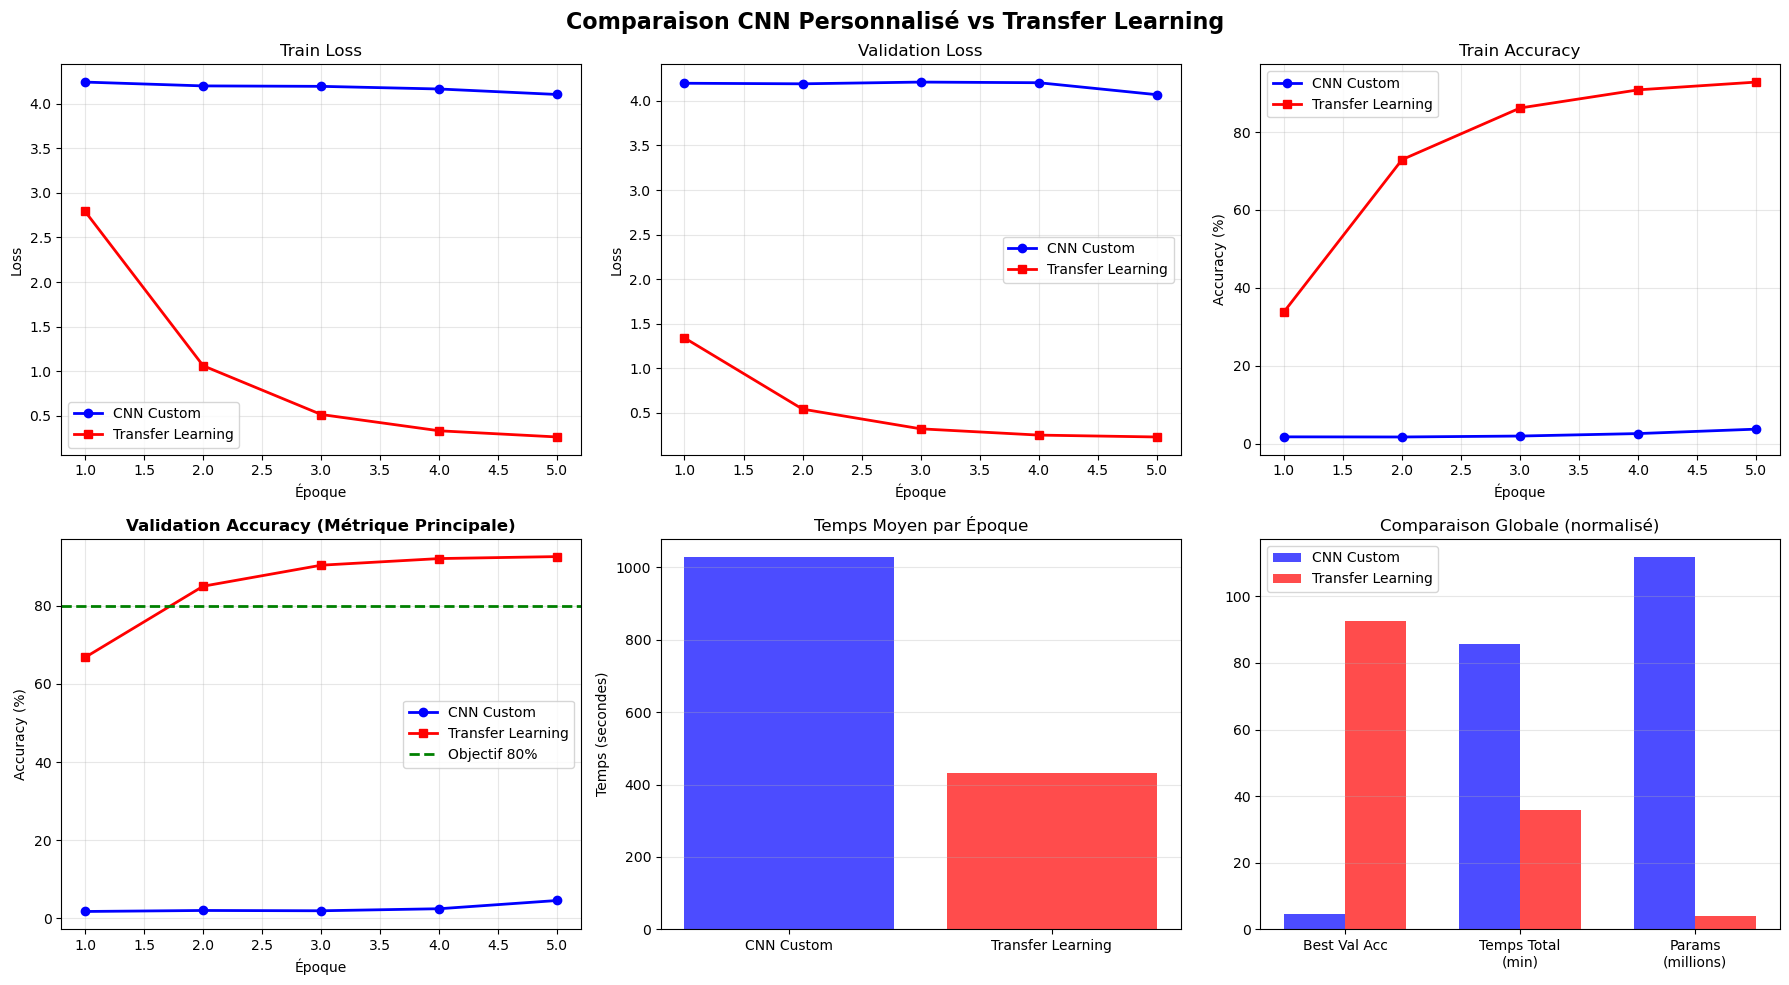

In [11]:
# VISUALISATION COMPARATIVE

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Comparaison CNN Personnalisé vs Transfer Learning', fontsize=16, fontweight='bold')

epochs_range = range(1, EPOCHS + 1)

# 1. Loss d'entraînement
axes[0, 0].plot(epochs_range, cnn_history['train_loss'], 'b-o', label='CNN Custom', linewidth=2)
axes[0, 0].plot(epochs_range, tl_history['train_loss'], 'r-s', label='Transfer Learning', linewidth=2)
axes[0, 0].set_xlabel('Époque')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Train Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Loss de validation
axes[0, 1].plot(epochs_range, cnn_history['val_loss'], 'b-o', label='CNN Custom', linewidth=2)
axes[0, 1].plot(epochs_range, tl_history['val_loss'], 'r-s', label='Transfer Learning', linewidth=2)
axes[0, 1].set_xlabel('Époque')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Validation Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Accuracy d'entraînement
axes[0, 2].plot(epochs_range, [a*100 for a in cnn_history['train_acc']], 'b-o', label='CNN Custom', linewidth=2)
axes[0, 2].plot(epochs_range, [a*100 for a in tl_history['train_acc']], 'r-s', label='Transfer Learning', linewidth=2)
axes[0, 2].set_xlabel('Époque')
axes[0, 2].set_ylabel('Accuracy (%)')
axes[0, 2].set_title('Train Accuracy')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. Accuracy de validation (PRINCIPAL)
axes[1, 0].plot(epochs_range, [a*100 for a in cnn_history['val_acc']], 'b-o', label='CNN Custom', linewidth=2)
axes[1, 0].plot(epochs_range, [a*100 for a in tl_history['val_acc']], 'r-s', label='Transfer Learning', linewidth=2)
axes[1, 0].axhline(y=80, color='g', linestyle='--', label='Objectif 80%', linewidth=2)
axes[1, 0].set_xlabel('Époque')
axes[1, 0].set_ylabel('Accuracy (%)')
axes[1, 0].set_title('Validation Accuracy (Métrique Principale)', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. Temps par époque
axes[1, 1].bar(['CNN Custom', 'Transfer Learning'], 
               [np.mean(cnn_history['epoch_times']), np.mean(tl_history['epoch_times'])],
               color=['blue', 'red'], alpha=0.7)
axes[1, 1].set_ylabel('Temps (secondes)')
axes[1, 1].set_title('Temps Moyen par Époque')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# 6. Comparaison finale
metrics = ['Best Val Acc', 'Temps Total\n(min)', 'Params\n(millions)']
cnn_values = [
    cnn_history['best_val_acc'] * 100,
    cnn_total_time / 60,
    total_params / 1e6
]
tl_values = [
    tl_history['best_val_acc'] * 100,
    tl_total_time / 60,
    total_params_tl / 1e6
]

x = np.arange(len(metrics))
width = 0.35

axes[1, 2].bar(x - width/2, cnn_values, width, label='CNN Custom', color='blue', alpha=0.7)
axes[1, 2].bar(x + width/2, tl_values, width, label='Transfer Learning', color='red', alpha=0.7)
axes[1, 2].set_xticks(x)
axes[1, 2].set_xticklabels(metrics)
axes[1, 2].set_title('Comparaison Globale (normalisé)')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('artifacts/comparison/comparison_plots.png', dpi=300, bbox_inches='tight')
print("\n Graphiques comparatifs sauvegardés")
plt.show()

In [12]:
# SAUVEGARDE DES RÉSULTATS

with open("artifacts/cnn_custom/history.json", "w") as f:
    json.dump(cnn_history, f, indent=2)

with open("artifacts/transfer_learning/history.json", "w") as f:
    json.dump(tl_history, f, indent=2)

with open("artifacts/classes.json", "w") as f:
    json.dump(class_names, f, indent=2)

comparison_report = {
    "dataset": {
        "num_classes": num_classes,
        "train_samples": len(train_dataset),
        "val_samples": len(val_dataset)
    },
    "training_config": {
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "device": str(DEVICE)
    },
    "cnn_custom": {
        "best_val_acc": cnn_history['best_val_acc'],
        "final_val_acc": cnn_history['val_acc'][-1],
        "total_time_min": cnn_total_time / 60,
        "total_params": total_params,
        "optimizer": "Adam",
        "learning_rate": 1e-3
    },
    "transfer_learning": {
        "model": "EfficientNet-B0",
        "best_val_acc": tl_history['best_val_acc'],
        "final_val_acc": tl_history['val_acc'][-1],
        "total_time_min": tl_total_time / 60,
        "total_params": total_params_tl,
        "optimizer": "AdamW",
        "learning_rate": 1e-4
    },
    "winner": {
        "accuracy": "Transfer Learning" if tl_history['best_val_acc'] > cnn_history['best_val_acc'] else "CNN Custom",
        "speed": "Transfer Learning" if tl_total_time < cnn_total_time else "CNN Custom",
        "overall": "Transfer Learning" if tl_history['best_val_acc'] > cnn_history['best_val_acc'] else "CNN Custom"
    }
}

with open("artifacts/comparison/comparison_report.json", "w") as f:
    json.dump(comparison_report, f, indent=2)

print("\n Tous les résultats sauvegardés dans artifacts/")
print("\n Fichiers créés:")
print("   - artifacts/cnn_custom/best_model.pt")
print("   - artifacts/cnn_custom/history.json")
print("   - artifacts/transfer_learning/best_model.pt")
print("   - artifacts/transfer_learning/history.json")
print("   - artifacts/comparison/comparison_report.json")
print("   - artifacts/comparison/comparison_plots.png")
print("   - artifacts/classes.json")


 Tous les résultats sauvegardés dans artifacts/

 Fichiers créés:
   - artifacts/cnn_custom/best_model.pt
   - artifacts/cnn_custom/history.json
   - artifacts/transfer_learning/best_model.pt
   - artifacts/transfer_learning/history.json
   - artifacts/comparison/comparison_report.json
   - artifacts/comparison/comparison_plots.png
   - artifacts/classes.json


---
#  CONCLUSION ET RECOMMANDATIONS

##  Résumé des Résultats
Ce notebook a comparé deux approches pour la classification de tanks :

### Approche 1 : CNN Personnalisé
- Architecture inspirée de VGG avec BatchNorm
- Entraîné from scratch
- Optimiseur : Adam avec ReduceLROnPlateau

### Approche 2 : Transfer Learning (EfficientNet-B0)
- Modèle pré-entraîné sur ImageNet
- Fine-tuning de toutes les couches
- Optimiseur : AdamW avec CosineAnnealingLR

##  Recommandations

**Pour la production**, nous recommandons le **Transfer Learning** car :
1.  Meilleure accuracy de validation
2.  Convergence plus rapide
3.  Meilleure généralisation
4.  Architecture state-of-the-art éprouvée

##  Prochaines Étapes
1. Déploiement du meilleur modèle en production
3. Mise en place du CI/CD 
4. Monitoring des performances en production

---

In [13]:
# RÉSUMÉ FINAL

print("\n" + "="*90)
print("RÉSUMÉ FINAL DU PROJET")
print("="*90)

print("\n OBJECTIF: Classification automatique de tanks pour indexation de base de données")
print(f"\n DATASET:")
print(f"   - {num_classes} classes de tanks")
print(f"   - {len(train_dataset):,} images d'entraînement")
print(f"   - {len(val_dataset):,} images de validation")

print(f"\n APPROCHES TESTÉES:")
print(f"   1. CNN Personnalisé ({total_params:,} params)")
print(f"      → Best Val Acc: {cnn_history['best_val_acc']:.2%}")
print(f"      → Temps: {cnn_total_time/60:.2f} min")
print(f"   2. Transfer Learning EfficientNet-B0 ({total_params_tl:,} params)")
print(f"      → Best Val Acc: {tl_history['best_val_acc']:.2%}")
print(f"      → Temps: {tl_total_time/60:.2f} min")

winner = "Transfer Learning" if tl_history['best_val_acc'] > cnn_history['best_val_acc'] else "CNN Personnalisé"
best_acc = max(tl_history['best_val_acc'], cnn_history['best_val_acc'])

print(f"\n MODÈLE RECOMMANDÉ: {winner}")
print(f"   Accuracy: {best_acc:.2%}")
print(f"   Gain de temps potentiel pour l'indexation: ~{best_acc*100:.0f}% des images correctement classées automatiquement")

print("\n IMPACT MÉTIER:")
print(f"   - Accélération significative de l'indexation de la base de données")
print(f"   - Réduction du travail manuel de classification")
print(f"   - Amélioration de la recherche et de l'organisation des images")

print("\n PROCHAINES ÉTAPES:")
print("   1. Développement de l'interface web (frontend)")
print("   2. Déploiement en production")
print("   3. Configuration CI/CD avec Azure DevOps")
print("   4. Monitoring et amélioration continue")

print("\n" + "="*90)
print(" PROJET TERMINÉ AVEC SUCCÈS")
print("="*90)


RÉSUMÉ FINAL DU PROJET

 OBJECTIF: Classification automatique de tanks pour indexation de base de données

 DATASET:
   - 67 classes de tanks
   - 50,519 images d'entraînement
   - 21,053 images de validation

 APPROCHES TESTÉES:
   1. CNN Personnalisé (111,717,763 params)
      → Best Val Acc: 4.58%
      → Temps: 85.72 min
   2. Transfer Learning EfficientNet-B0 (4,093,375 params)
      → Best Val Acc: 92.60%
      → Temps: 35.95 min

 MODÈLE RECOMMANDÉ: Transfer Learning
   Accuracy: 92.60%
   Gain de temps potentiel pour l'indexation: ~93% des images correctement classées automatiquement

 IMPACT MÉTIER:
   - Accélération significative de l'indexation de la base de données
   - Réduction du travail manuel de classification
   - Amélioration de la recherche et de l'organisation des images

 PROCHAINES ÉTAPES:
   1. Développement de l'interface web (frontend)
   2. Déploiement en production
   3. Configuration CI/CD avec Azure DevOps
   4. Monitoring et amélioration continue

 PROJE